# Case 3
Cognitive Systems for Health Technology Applications<br>
Matias Säilä<br>
[Helsinki Metropolia University of Applied Sciences](http:/www.metropolia.fi/en)

## Processing raw data
Based on listing 6.8 (p. 189) Chollet: Deep Learning with Python, 2018.

In [3]:
import os
import time

ohsumed_dir = 'ohsumed-first-20000-docs/'
train_dir = os.path.join(ohsumed_dir, 'training')

labels = []
texts = []



t1 = time.time()
# Generate a list L = ['C01', 'C02, ..., 'C023']
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)
        

## Tokenize the text of the raw data
Based on listing 6.9 (p. 189)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 250
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 30857 unique tokens


### Shape the data and labels

In [5]:
from keras.utils.np_utils import to_categorical

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)


print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 250)
Shape of labels tensor: (10433, 23)


### Shuffle the data and labels

In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

## Build the model
Listing 6.7 (p. 187)

In [13]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(L), activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              25601024  
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_9 (Dense)              (None, 23)                5911      
Total params: 26,869,335
Trainable params: 26,869,335
Non-trainable params: 0
_________________________________________________________________


## Train the model

Tested with multiple different settings and these was the bet outcome. Results are not good but they were still the best out of my testings. Validation accuracy was the hardest to contain at high level.

Some test results here

Max words = 8  
Epochs = 10  
Batch_size= 32  
=> Accuracy 0,55 and Val_acc 0,10 


Max words = 32  
Epochs = 10  
Batch_size= 45  
=> Accuracy 0,57 and Val_acc 0,12

Max words = 50  
Epochs = 10  
Batch_size= 50  
=> Accuracy 0,58 and Val_acc 0,14



In [14]:
import time

t1 = time.time()
history = model.fit(data, one_hot_labels,
                   epochs = 15,
                   batch_size = 60,
                   validation_split = 0.2)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 8346 samples, validate on 2087 samples
Epoch 1/15
8346/8346 [==============================] - 87s 10ms/step - loss: 2.8037 - acc: 0.1780 - val_loss: 2.6867 - val_acc: 0.2333
Epoch 2/15
8346/8346 [==============================] - 87s 10ms/step - loss: 2.1575 - acc: 0.3271 - val_loss: 2.8691 - val_acc: 0.1576
Epoch 3/15
8346/8346 [==============================] - 87s 10ms/step - loss: 1.4703 - acc: 0.4931 - val_loss: 3.3347 - val_acc: 0.1394
Epoch 4/15
8346/8346 [==============================] - 87s 10ms/step - loss: 1.1193 - acc: 0.5288 - val_loss: 3.4776 - val_acc: 0.1466
Epoch 5/15
8346/8346 [==============================] - 87s 10ms/step - loss: 0.9187 - acc: 0.5410 - val_loss: 4.3379 - val_acc: 0.1313
Epoch 6/15
8346/8346 [==============================] - 89s 11ms/step - loss: 0.8078 - acc: 0.5502 - val_loss: 4.5634 - val_acc: 0.1548
Epoch 7/15
8346/8346 [==============================] - 89s 11ms/step - loss: 0.7530 - acc: 0.5592 - val_loss: 5.2873 - val_acc: 0.1533


## Training results

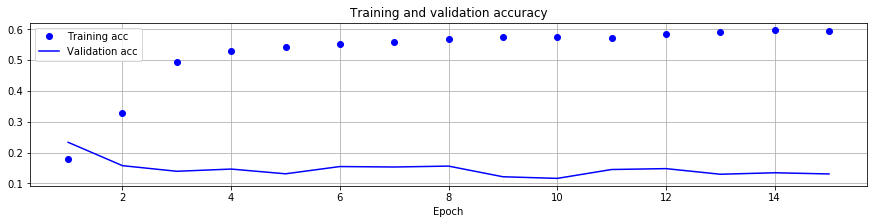

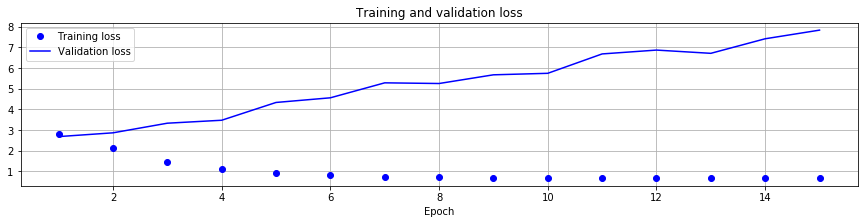

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Metrics results

In [16]:
# Calculate the predictions
predictions = model.predict(data)
y_pred = np.argmax(predictions, axis = 1)

In [17]:
# http://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score

In [18]:
# Classification results per class
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.53      0.46      0.49       423
          1       0.48      0.42      0.45       158
          2       0.59      0.46      0.52        65
          3       0.59      0.66      0.63      1163
          4       0.47      0.71      0.57       283
          5       0.50      0.71      0.59       588
          6       0.66      0.38      0.48       100
          7       0.48      0.66      0.55       473
          8       0.49      0.70      0.58       125
          9       0.53      0.57      0.55       621
         10       0.78      0.36      0.50       162
         11       0.53      0.71      0.61       491
         12       0.73      0.37      0.49       281
         13       0.67      0.63      0.65      1249
         14       0.47      0.50      0.48       215
         15       0.74      0.29      0.42       200
         16       0.37      0.78      0.50       295
         17       0.77      0.48      0.59   

In [19]:
# Confusion matrix
cm = confusion_matrix(labels, y_pred)
print(np.array2string(cm, max_line_width = 100))

[[196   7   2  13  22  32   2  29   5   7   3  16   3  21   8   1  16   1   1   6  10   4  18]
 [  9  66   2   5   1  11   1  12   1   4   0   4   3   5   0   0  10   0   0  14   0   2   8]
 [  4   1  30   1   0   4   0   3   0   4   3   0   0   2   1   0   2   0   0   1   1   1   7]
 [  4   9   2 771   5  54   6  50  20  23   2  77   2  10  16   4  43   3   3   6   7   1  45]
 [  3   0   0   6 201   1   0   2   1   6   0   2   0   3   1   2  31   0   1   2   6   3  12]
 [ 11   1   1  40   9 420   0  12   0   3   0   9   1   3   3   1  14   0   0   2   6   3  49]
 [  1   2   0  22   4   1  38   1   1   3   0   1   0   4   1   0   9   0   0   1   0   0  11]
 [  6   3   2  21   7  12   1 310  15   5   0   5   0  23   8   2  15   0   0   7   6   3  22]
 [  0   2   0   9   1   0   0   6  88   2   0   1   0   0   0   0   8   0   0   1   1   0   6]
 [ 12   2   2  33  28  18   0   7   3 352   0   9   1  24   4   0  25   1   1   6  14   2  77]
 [  5   3   2  14   4   2   0   2   1  11  59   1 

In [20]:
print(texts[indices[512]])

24-hour intragastric acidity and plasma gastrin after omeprazole treatment and after proximal gastric vagotomy in duodenal ulcer patients 
 The relationship between suppressed gastric acidity and the increase in plasma gastrin levels after pharmacological and surgical treatment of peptic ulcer disease were compared in this study.
 Eight patients with chronic duodenal ulcer and referred for proximal gastric vagotomy were studied.
 24-hour intragastric acidity and plasma gastrin levels were investigated in the same patients on three consecutive occasions: preentry without any treatment; after 4 weeks of administration of 20 mg of omeprazole daily, and 4-6 months after proximal gastric vagotomy.
 Intragastric acidity was slightly more reduced by omeprazole (94%) than after proximal gastric vagotomy (78%), with no difference found during the day or night with either.
 Plasma gastrin levels increased slightly more after proximal gastric vagotomy [284% (median, 2120 pmol.h/L; range, 733-2831

True class:  5
Predicted class: 5
Predictions per class:
[  8.29e-10   4.09e-13   7.11e-17   8.23e-07   4.86e-08   1.00e+00
   6.28e-12   1.71e-08   1.17e-09   1.31e-06   7.65e-09   6.77e-10
   2.31e-08   7.37e-08   2.20e-10   3.97e-13   2.74e-07   2.46e-09
   6.84e-11   8.89e-11   1.38e-08   2.16e-09   1.61e-06]


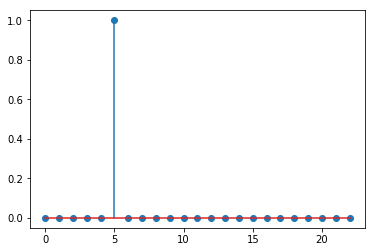

In [21]:
print('True class: ', labels[512])
print('Predicted class:', y_pred[512])
print('Predictions per class:')
print(np.array2string(predictions[512], precision = 2))

plt.stem(predictions[512])
plt.show()

In [22]:
np.__version__

'1.12.1'

#  Results and conclusions  

This was really hard, and i tried many combos to get the accuracy up, the the results almost didnt change at all. Very frustrate. The best result i got is in the code right now.